<a href="https://colab.research.google.com/github/stanislavfort/OpenAI_CLIP_adversarial_examples/blob/main/presentable_OpenAI_CLIP_stickers_and_adversaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class name stickers and adversarial examples for the OpenAI CLIP model

In this Colab I first verify the zero-shot performance of the OpenAI CLIP model (https://github.com/openai/CLIP) on CIFAR-10, reaching approximately 87.8%. I then show that adding spelled out class names into the test images increases the performance to 100%. Then I show that we can flip the classification decision by plastering a sticker with the desired class name into the image, and that this classification can be changed again by introducing an adversarial perturbation to the image pixels -- a slight perturbations to image that leads to confident misclassification by the model. Finally I show how we can change this decision once again by introducing yet anothe class name sticker into the image, which can again be changed by an adversarial perturbation.

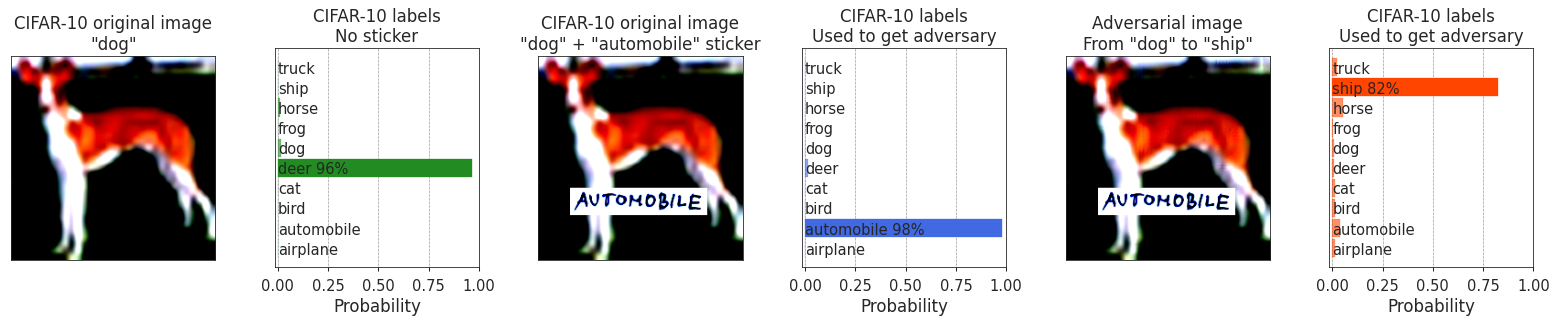

# Dependencies

In [1]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

import matplotlib.pyplot as plt

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.2MB/s eta 0:04:39tcmalloc: large alloc 1147494400 bytes == 0x559a20b8c000 @  0x7f7dd1624615 0x5599e69c506c 0x5599e6aa4eba 0x5599e69c7e8d 0x5599e6ab999d 0x5599e6a3bfe9 0x5599e6a36b0e 0x5599e69c977a 0x5599e6a3be50 0x5599e6a36b0e 0x5599e69c977a 0x5599e6a3886a 0x5599e6aba7c6 0x5599e6a37ee2 0x5599e6aba7c6 0x5599e6a37ee2 0x5599e6aba7c6 0x5599e6a37ee2 0x5599e6aba7c6 0x5599e6b3c431 0x5599e6a9d049 0x5599e6a07c84 0x5599e69c88e9 0x5599e6a3cade 0x5599e69c969a 0x5599e6a37a45 0x5599e6a36e0d 0x5599e69c977a 0x5599e6a37a45 0x5599e69c969a 0x5599e6a37a45
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:27tcmalloc: large alloc 1434370048 bytes == 0x559a651e2000 @  0x7f7dd1624615 0x5599e69c506c 0x5599e6aa4eba 0x5599e69c7e8d 0x5599e6ab999d 0x5599e6a3bfe9 0x5599e6a36b0e 0x5599e69c977a 0x5599e6a3be50 0x5599e6a36b0e 0x5599e69c977a 0x5599e6a3886a 0x5599e6aba7

In [3]:
import requests
import PIL
import io

# Downloading OpenAI CLIP from GitHub

In [2]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 70 (delta 0), reused 1 (delta 0), pack-reused 64
Unpacking objects: 100% (70/70), done.
/content/CLIP


# Getting CIFAR-10 and CIFAR-100

## Choose dataset

In [4]:
dataset_choice = "CIFAR10"

## Load dataset

In [6]:
import keras
from keras.datasets import cifar10

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
else:
  assert False

y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])

N_train = len(y_train)

# Input image dimensions.
input_shape = x_train.shape[1:]

#keeping the originals
x_train_unnormed = np.array(x_train)
x_test_unnormed = np.array(x_test)


## Original class names

In [7]:
cifar10_class_names = [
  "airplane",								
  "automobile", 										
  "bird", 										
  "cat", 										
  "deer", 										
  "dog", 										
  "frog", 										
  "horse", 										
  "ship", 										
  "truck"
  ]

In [8]:
if dataset_choice == "CIFAR10":
  candidate_captions = cifar10_class_names
  class_names = cifar10_class_names
else:
  assert False

# Getting class name stickers

(150, 33)


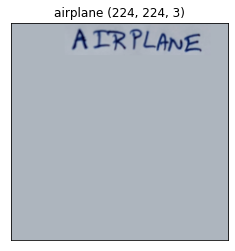

(150, 30)


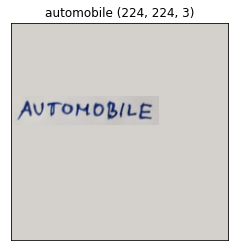

(150, 47)


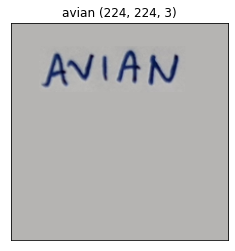

(150, 62)


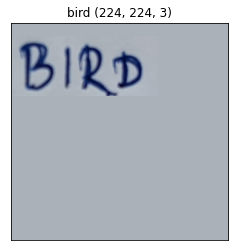

(150, 72)


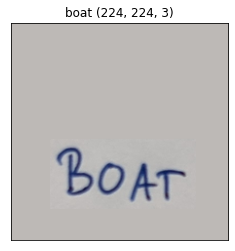

(150, 70)


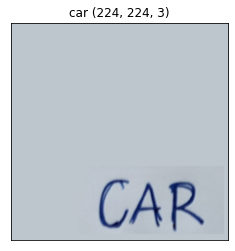

(150, 54)


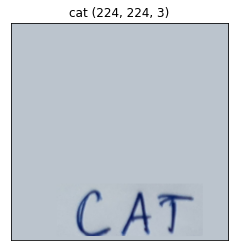

(150, 55)


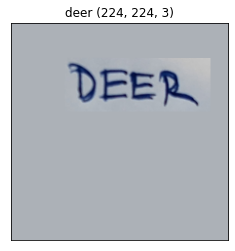

(150, 63)


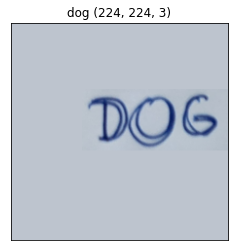

(150, 56)


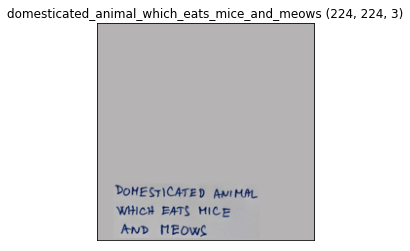

(150, 46)


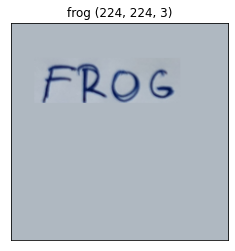

(150, 46)


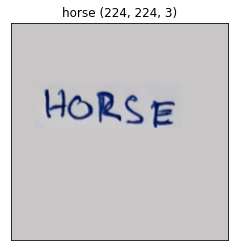

(150, 50)


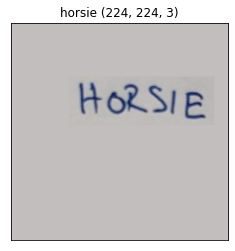

(150, 75)


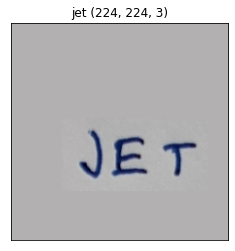

(150, 46)


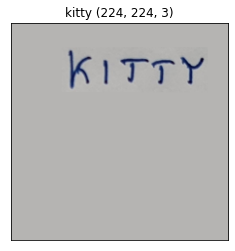

(150, 60)


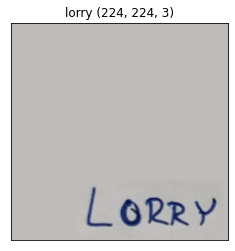

(150, 57)


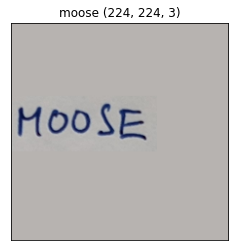

(150, 78)


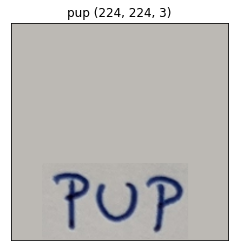

(150, 71)


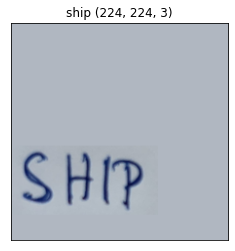

(150, 58)


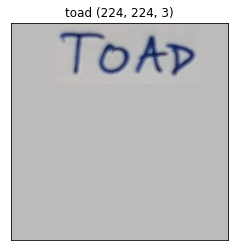

(150, 53)


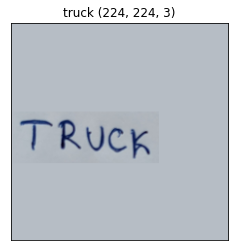

(150, 36)


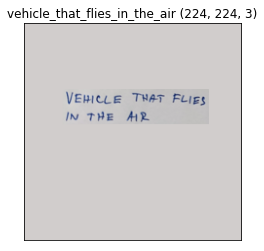

In [10]:
import requests
import PIL
import io
import matplotlib.pyplot as plt

target_image_size = 150 #the larger size of the sticker
actual_size = 224 #the size of the images used for CLIP, keep fixed

assert actual_size == 224

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

image_filenames = [
  "sticker_airplane.png",
  "sticker_automobile.png",
  "sticker_avian.png",
  "sticker_bird.png",
  "sticker_boat.png",
  "sticker_car.png",
  "sticker_cat.png",
  "sticker_deer.png",
  "sticker_dog.png",
  "sticker_domesticated_animal_which_eats_mice_and_meows.png",
  "sticker_frog.png",
  "sticker_horse.png",
  "sticker_horsie.png",
  "sticker_jet.png",
  "sticker_kitty.png",
  "sticker_lorry.png",
  "sticker_moose.png",
  "sticker_pup.png",
  "sticker_ship.png",
  "sticker_toad.png",
  "sticker_truck.png",
  "sticker_vehicle_that_flies_in_the_air.png",
]

sticker_dict = dict()

for c,image_name in enumerate(image_filenames):
  image_pil = download_image("https://raw.githubusercontent.com/stanislavfort/OpenAI_CLIP_adversarial_examples/main/stickers/"+image_name)
  class_name = image_name.split("sticker_")[1].split(".png")[0]

  if class_name not in sticker_dict:
    sticker_dict[class_name] = ([],[]) #images, masks

  w,h = image_pil.size

  ratio = float(target_image_size) / max([w,h])
  image_pil_resized = image_pil.resize((int(ratio*w),int(ratio*h)))

  print(image_pil_resized.size)

  image_np = np.array(image_pil_resized)

  image_np = image_np[:,:,:3] #removing the last channel

  positions = 100
  for _ in range(positions):
    x1 = np.random.choice(range(0,actual_size-image_np.shape[1]))
    y1 = np.random.choice(range(0,actual_size-image_np.shape[0]))

    full_image_np = np.ones((actual_size,actual_size,3))*(image_np[0,0].reshape([1,1,3]))
    full_image_np[y1:image_np.shape[0]+y1,x1:image_np.shape[1]+x1,:] = image_np
    full_image_np = full_image_np.astype(np.uint8)

    full_mask_np = np.zeros((1,1,actual_size,actual_size))
    full_mask_np[0,0,y1:image_np.shape[0]+y1,x1:image_np.shape[1]+x1] = 1

    sticker_dict[class_name][0].append(full_image_np)
    sticker_dict[class_name][1].append(full_mask_np)

  plt.title(class_name+" "+str(full_image_np.shape))
  plt.imshow(full_image_np)
  plt.xticks([],[])
  plt.yticks([],[])
  plt.show()


# Run CLIP on the test set to check performance

In [11]:
import torch
import clip
from PIL import Image

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, transform = clip.load("ViT-B/32", device=device) #loading the clip checkpoints

text = clip.tokenize(candidate_captions).to(device) #tokenizing the candidate labels

#for on the fly accuracy estimate
collecting_predictions_list = []
collecting_ground_truth_list = []

N_to_check = -1 #full dataset
# N_to_check = 500 #first 500

for i,img in enumerate(x_test_unnormed[:N_to_check]):

  if i % 100 == 0:
    if len(collecting_predictions_list) > 0:
      collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
      acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
    else:
      acc_now = None
    print(str(i)+"/"+str(len(x_test_unnormed[:N_to_check]))+" test accuracy so far="+str(acc_now))

  img_PIL = Image.fromarray(np.uint8(img))
  image = transform(img_PIL).unsqueeze(0).to(device)

  with torch.no_grad():
    
    logits_from_image, logits_from_text = model(image, text)
    probs_now = logits_from_image.softmax(dim=-1).cpu().numpy()

    collecting_predictions_list.append(probs_now)
    collecting_ground_truth_list.append(y_test[i])





100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 63.9MiB/s]


0/9999 test accuracy so far=None
100/9999 test accuracy so far=0.87
200/9999 test accuracy so far=0.865
300/9999 test accuracy so far=0.8766666666666667
400/9999 test accuracy so far=0.8825
500/9999 test accuracy so far=0.88
600/9999 test accuracy so far=0.8783333333333333
700/9999 test accuracy so far=0.8771428571428571
800/9999 test accuracy so far=0.8775
900/9999 test accuracy so far=0.88
1000/9999 test accuracy so far=0.876
1100/9999 test accuracy so far=0.8754545454545455
1200/9999 test accuracy so far=0.8766666666666667
1300/9999 test accuracy so far=0.8792307692307693
1400/9999 test accuracy so far=0.8778571428571429
1500/9999 test accuracy so far=0.8786666666666667
1600/9999 test accuracy so far=0.88
1700/9999 test accuracy so far=0.8829411764705882
1800/9999 test accuracy so far=0.8838888888888888
1900/9999 test accuracy so far=0.8836842105263157
2000/9999 test accuracy so far=0.883
2100/9999 test accuracy so far=0.8833333333333333
2200/9999 test accuracy so far=0.880454545454

## Test set accuracy

In [12]:
collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
print("Test accuracy = "+str(acc_now))

Test accuracy = 0.8736873687368737


# Test set + ground truth class stickers

In [16]:
text = clip.tokenize(candidate_captions).to(device)

collecting_predictions_list = []
collecting_ground_truth_list = []

N_to_check = -1 #full dataset
# N_to_check = 500 #first 500

for i,img in enumerate(x_test_unnormed[:N_to_check]):

  if i % 100 == 0:
    if len(collecting_predictions_list) > 0:
      collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
      acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
    else:
      acc_now = None
    print(str(i)+"/"+str(len(x_test_unnormed[:N_to_check]))+" test + ground truth sticker accuracy so far="+str(acc_now))

  img_PIL = Image.fromarray(np.uint8(img))
  image = transform(img_PIL).unsqueeze(0).to(device)

  if True: #adding a ground truth sticker
    sticker_c = y_test[i]
    sticker_i = np.random.choice(range(len(sticker_dict[cifar10_class_names[sticker_c]][0])))

    image_sticker = transform(Image.fromarray(np.uint8(sticker_dict[cifar10_class_names[sticker_c]][0][sticker_i]))).unsqueeze(0).to(device)
    sticker_mask = torch.Tensor(sticker_dict[cifar10_class_names[sticker_c]][1][sticker_i]).to(device)
    image = image_sticker*sticker_mask + image*(1-sticker_mask)

  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    collecting_predictions_list.append(probs)
    collecting_ground_truth_list.append(y_test[i])


0/9999 test accuracy so far=None
100/9999 test accuracy so far=1.0
200/9999 test accuracy so far=1.0
300/9999 test accuracy so far=1.0
400/9999 test accuracy so far=1.0
500/9999 test accuracy so far=1.0
600/9999 test accuracy so far=1.0
700/9999 test accuracy so far=1.0
800/9999 test accuracy so far=1.0
900/9999 test accuracy so far=1.0
1000/9999 test accuracy so far=1.0
1100/9999 test accuracy so far=1.0
1200/9999 test accuracy so far=1.0
1300/9999 test accuracy so far=1.0
1400/9999 test accuracy so far=1.0
1500/9999 test accuracy so far=1.0
1600/9999 test accuracy so far=1.0
1700/9999 test accuracy so far=1.0
1800/9999 test accuracy so far=1.0
1900/9999 test accuracy so far=1.0
2000/9999 test accuracy so far=1.0
2100/9999 test accuracy so far=1.0
2200/9999 test accuracy so far=1.0
2300/9999 test accuracy so far=1.0
2400/9999 test accuracy so far=1.0
2500/9999 test accuracy so far=1.0
2600/9999 test accuracy so far=1.0
2700/9999 test accuracy so far=1.0
2800/9999 test accuracy so far=

## Test set + ground truth stickers accuracy

In [17]:
collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
print("Test + ground truth stickers accuracy = "+str(acc_now))

Test + ground truth stickers accuracy = 1.0


## Showing images with stickers

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

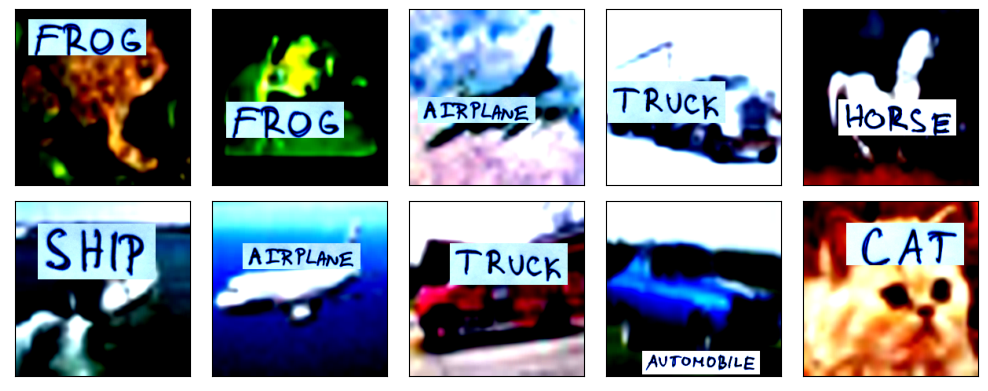

In [20]:
per_row = 5
to_show = 10
rows = int(np.ceil(float(to_show) / float(per_row)))

plt.figure(figsize = (2*per_row,2*rows),dpi=100)
for i in range(to_show):

  id_to_use = np.random.choice(range(len(x_test_unnormed)))
  img = x_test_unnormed[id_to_use]
  
  img_PIL = Image.fromarray(np.uint8(img))
  image = transform(img_PIL).unsqueeze(0).to(device)

  if True: #adding a sticker
    sticker_c = y_test[id_to_use]
    sticker_i = np.random.choice(range(len(sticker_dict[cifar10_class_names[sticker_c]][0])))

    image_sticker = transform(Image.fromarray(np.uint8(sticker_dict[cifar10_class_names[sticker_c]][0][sticker_i]))).unsqueeze(0).to(device)
    sticker_mask = torch.Tensor(sticker_dict[cifar10_class_names[sticker_c]][1][sticker_i]).to(device)
    image = image_sticker*sticker_mask + image*(1-sticker_mask)

  plt.subplot(rows,per_row,i+1)
  plt.imshow(image.detach().cpu().numpy()[0].transpose([1,2,0]))
  plt.xticks([],[])
  plt.yticks([],[])

plt.tight_layout()

plt.show()

# Encapsulating classification into wrapper

In [18]:
def classify_images(images_np, class_texts, skip_transform = False,verbose = True):

  text = clip.tokenize(class_texts).to(device)

  collecting_predictions_list = []
  collecting_ground_truth_list = []

  for i,img in enumerate(images_np):

    if verbose and (i % 50 == 0):
      print(i)


    if skip_transform == False:
      img_PIL = Image.fromarray(np.uint8(img))
      image = transform(img_PIL).unsqueeze(0).to(device)
    else:
      image = torch.Tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
      
      logits_from_image, logits_from_text = model(image, text)
      probs = logits_from_image.softmax(dim=-1).cpu().numpy()

      collecting_predictions_list.append(probs)
      collecting_ground_truth_list.append(y_test[i])

  return np.concatenate(collecting_predictions_list,axis=0)


In [19]:
subset_size = 1000
preds_now = classify_images(x_train_unnormed[:subset_size], class_names)
acc_now = np.mean(np.argmax(preds_now,axis=-1) == y_train[:subset_size])
print("train subset accuracy = "+str(acc_now))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
train subset accuracy = 0.865


# Plotting style

In [21]:
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2, 
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE, 
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

# Wrapper for adversary finding

In [22]:
cifar10_class_names = [
  "airplane",								
  "automobile", 										
  "bird", 										
  "cat", 										
  "deer", 										
  "dog", 										
  "frog", 										
  "horse", 										
  "ship", 										
  "truck"
  ]

In [29]:
def get_adversary(image,target_label, LR=0.3, steps=30):

  for step in range(steps):

    #getting the model for grad setup
    criterion = torch.nn.CrossEntropyLoss()

    inputs = image
    labels = torch.Tensor([target_label]).reshape([1]).to(device)

    inputs.requires_grad = True

    outputs, _ = model(image, text)
    probs = outputs.softmax(dim=-1).detach().cpu().numpy()

    loss = criterion(outputs, labels.long())

    inputs.retain_grad()
    loss.retain_grad()

    loss.backward()

    loss_out_np = loss.data.detach().cpu().numpy()

    image_grad = inputs.grad.detach().cpu().numpy()

    image_np = image.detach().cpu().numpy() - LR*image_grad
    image = torch.Tensor(image_np)

  return image_np

# Class finding util

In [30]:
def get_different_class(cs_toexclude,classes = 10):
  classes_kept = [c for c in range(classes) if c not in cs_toexclude]
  return int(np.random.choice(classes_kept,()))

# Experiment 1: Original -> +sticker -> +adversarial perturbation

In [33]:
N_adversaries = 10 #number of images to run

LR = 0.3
steps = 30

#collecting images and labels
collected_original_images_nosticker = []
collected_original_images = []
collected_original_labels = []
collected_sticker_labels = []
collected_modified_images = []
collected_modified_labels = []

for j in range(N_adversaries):

  print("Image "+str(j)+"/"+str(N_adversaries))

  id_chosen = int(np.random.choice(range(len(x_train_unnormed)),()))

  true_label = y_train[id_chosen]
  target_label = get_different_class([int(true_label)])

  print("True label = "+str(true_label)+" target label = "+str(target_label))

  img_PIL = Image.fromarray(np.uint8(x_train_unnormed[id_chosen]))
  image = transform(img_PIL).unsqueeze(0).to(device)

  collected_original_images_nosticker.append(image.detach().cpu().numpy())

  if True: #adding a sticker
    sticker_c = get_different_class([int(true_label),int(target_label)])
    collected_sticker_labels.append(sticker_c)
    sticker_i = np.random.choice(range(len(sticker_dict[cifar10_class_names[sticker_c]][0])))
  
    image_sticker = transform(Image.fromarray(np.uint8(sticker_dict[cifar10_class_names[sticker_c]][0][sticker_i]))).unsqueeze(0).to(device)
    sticker_mask = torch.Tensor(sticker_dict[cifar10_class_names[sticker_c]][1][sticker_i]).to(device)
    image = image_sticker*sticker_mask + image*(1-sticker_mask)
  
  image_original_np = image.detach().cpu().numpy()

  collected_original_images.append(image_original_np)

  collected_original_labels.append(true_label)

  collected_modified_labels.append(target_label)

  image_np = get_adversary(image,target_label, LR=LR, steps=steps)

  collected_modified_images.append(image_np)


Image 0/10
True label = 5 target label = 8
Image 1/10
True label = 0 target label = 1
Image 2/10
True label = 3 target label = 4
Image 3/10
True label = 0 target label = 7
Image 4/10
True label = 9 target label = 0
Image 5/10
True label = 3 target label = 9
Image 6/10
True label = 8 target label = 5
Image 7/10
True label = 5 target label = 9
Image 8/10
True label = 5 target label = 8
Image 9/10
True label = 5 target label = 1


## Predictions

In [35]:
original_preds_nosticker_now = classify_images(np.concatenate(collected_original_images_nosticker,axis=0), cifar10_class_names, skip_transform=True, verbose=False)
original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), cifar10_class_names, skip_transform=True, verbose=False)
modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), cifar10_class_names, skip_transform=True, verbose=False)

## Plotting

In [36]:
def v2_make_plot_from_preds(orig_preds,class_labels,colors = ["forestgreen"]):

  width = 0.45

  for i in range(orig_preds.shape[0]):
    v_orig = orig_preds[i]
    alpha_orig = 0.6

    if np.argmax(orig_preds) == i:
      alpha_orig = 1.0
      
    plt.fill_between([0,v_orig],[i-width,i-width],[i+width,i+width], color = colors[0],alpha = alpha_orig)

  for i in range(len(class_labels)):
    text = class_labels[i]
    if orig_preds[i] > 0.3:
      text = text + " " + str(int(orig_preds[i]*100))+"%"
    plt.text(0,i-0.3,text,fontsize = 14)

  plt.xticks(fontsize = 14)
  plt.yticks([],[])

  plt.xlabel("Probability",fontsize = 16)
  plt.xlim([-0.015,1.0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


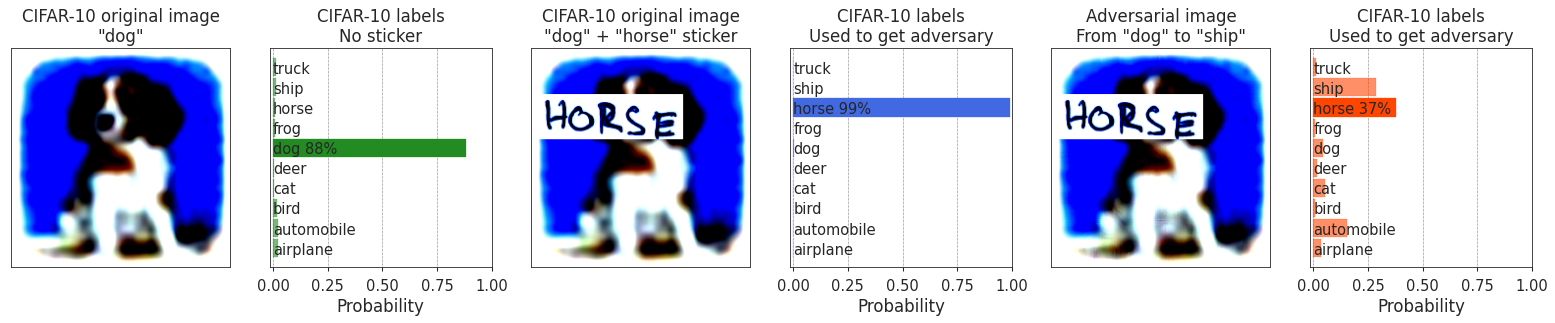

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


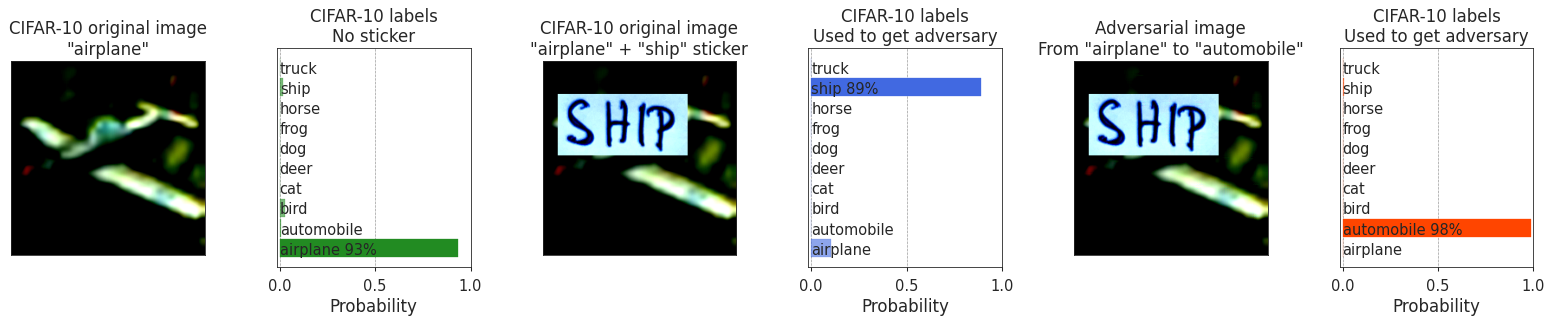

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


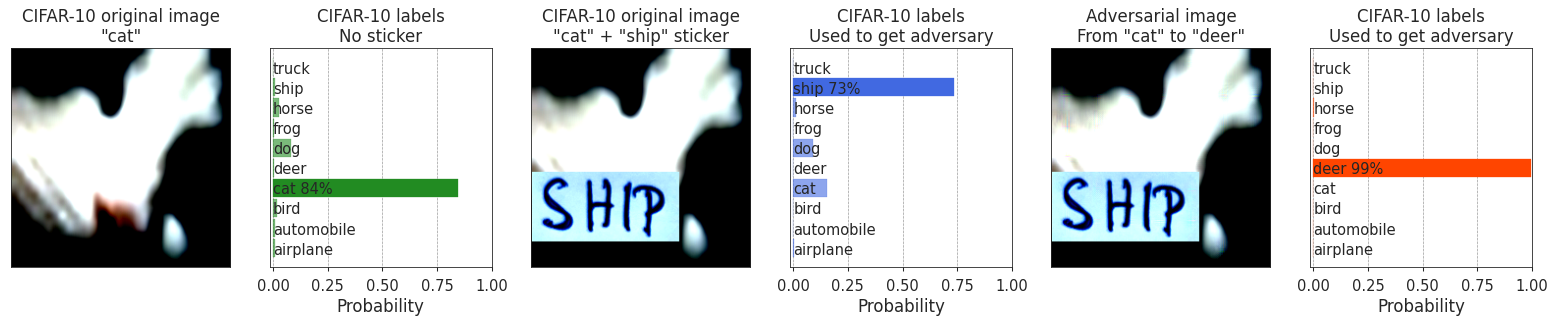

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


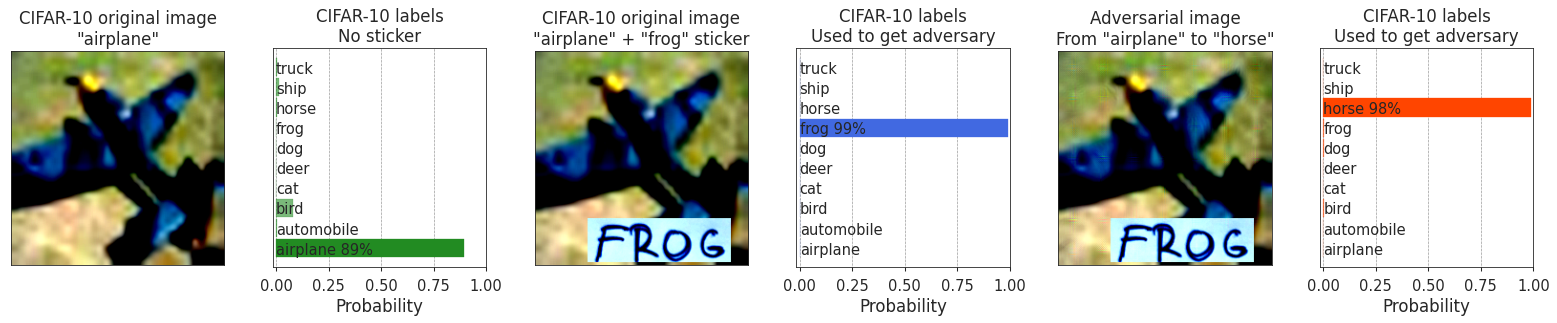

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


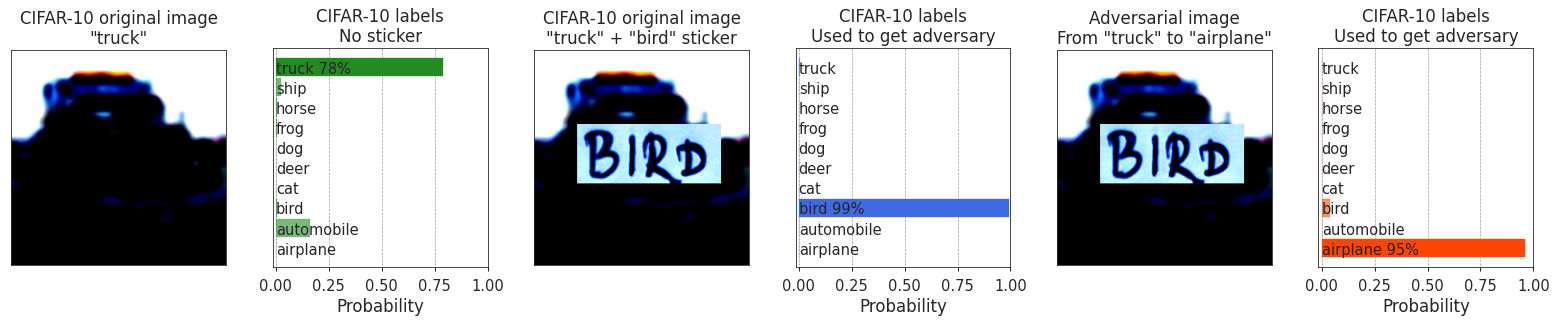

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


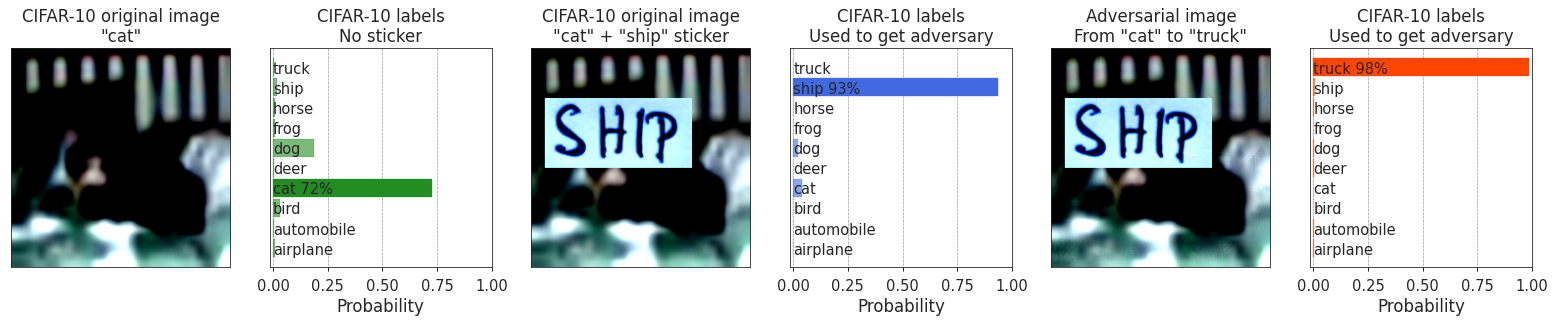

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


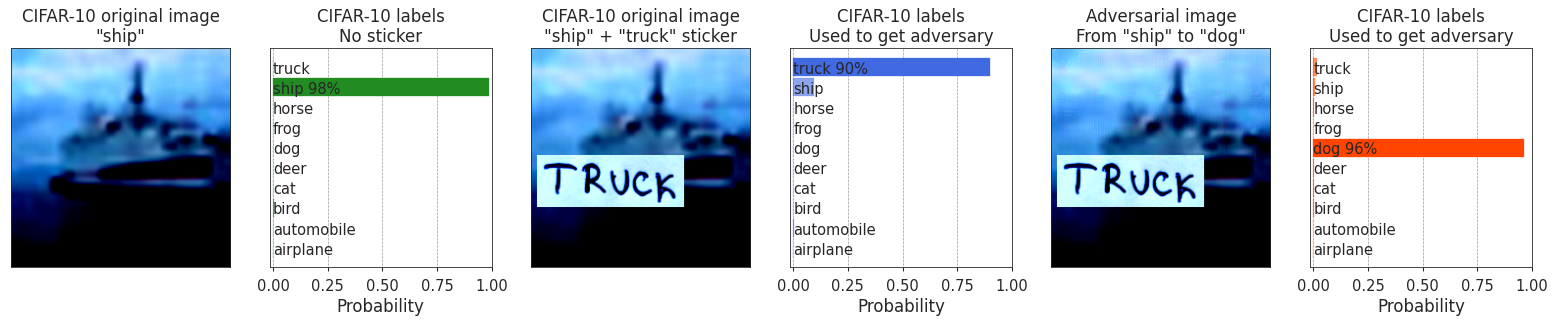

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


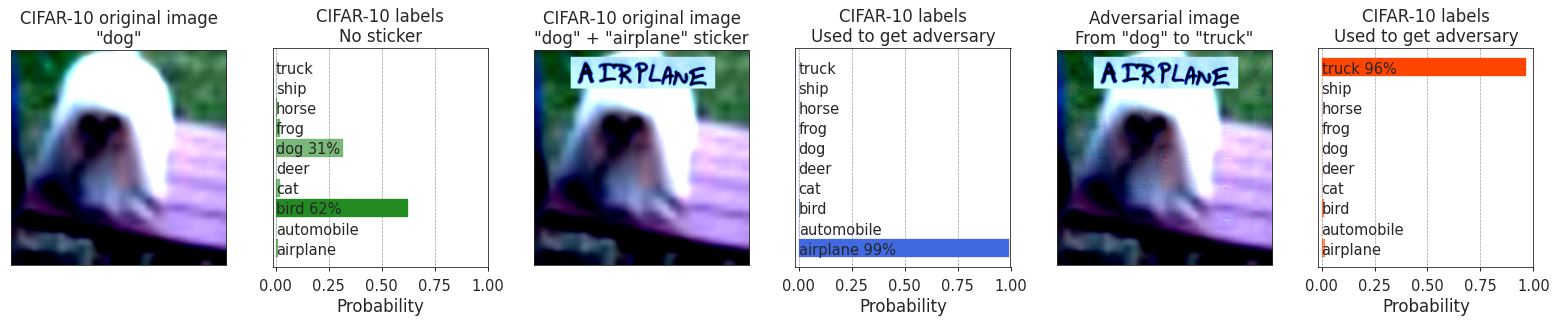

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


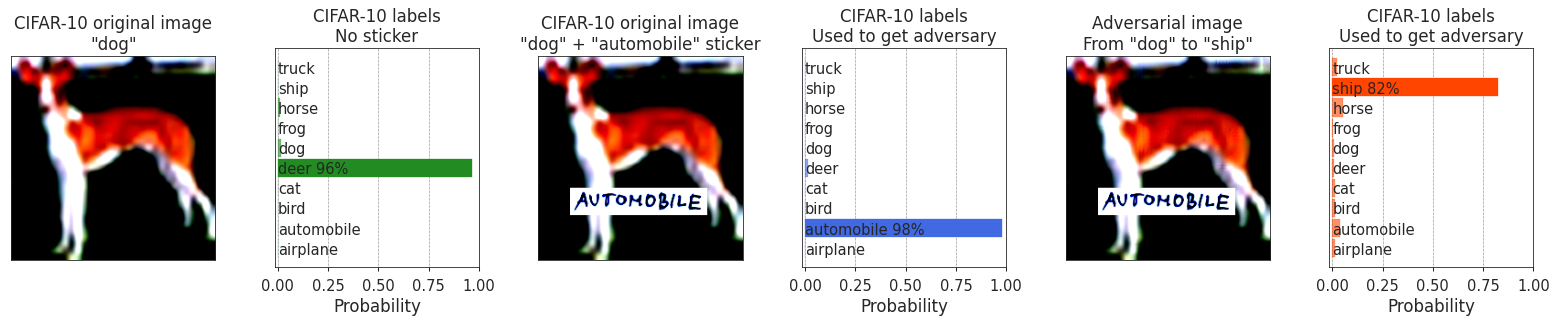

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


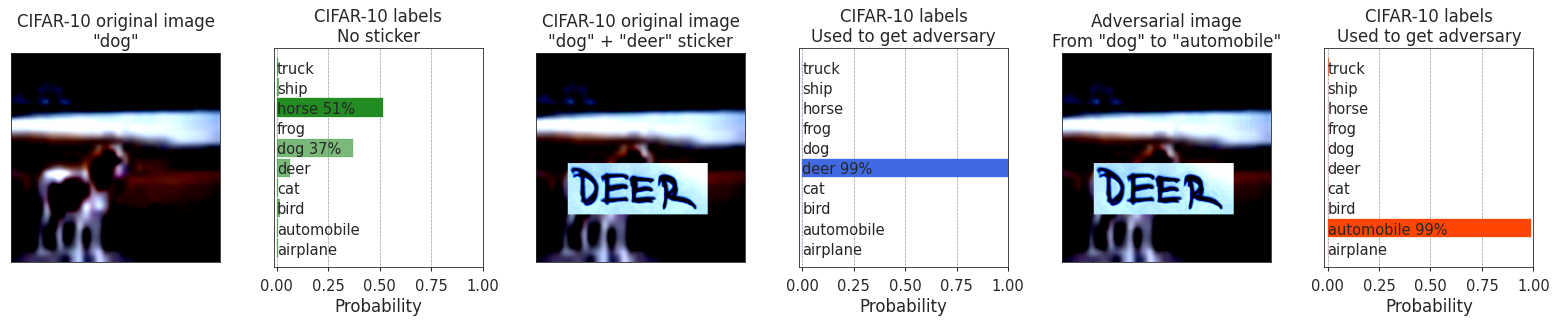

In [37]:
for id_to_show in range(original_preds_now.shape[0]):

  plt.figure(figsize = (6*3.5,4.5),dpi = 75)

  plt.subplot(1,6,2)
  plt.title("CIFAR-10 labels\nNo sticker",fontsize = 16)
  v2_make_plot_from_preds(original_preds_nosticker_now[id_to_show],class_names,colors = ["forestgreen"])
  # plt.ylabel("Original dataset labels")

  plt.subplot(1,6,4)
  plt.title("CIFAR-10 labels\nUsed to get adversary",fontsize = 16)
  v2_make_plot_from_preds(original_preds_now[id_to_show],class_names,colors = ["royalblue"])
  # plt.ylabel("Original dataset labels")

  plt.subplot(1,6,6)
  plt.title("CIFAR-10 labels\nUsed to get adversary",fontsize = 16)
  v2_make_plot_from_preds(modified_preds_now[id_to_show],class_names,colors = ["orangered"])
  # plt.ylabel("Original dataset labels")

  plt.subplot(1,6,1)
  plt.title("CIFAR-10 original image\n\""+class_names[collected_original_labels[id_to_show]]+"\"",fontsize = 16)
  plt.imshow(collected_original_images_nosticker[id_to_show][0].transpose([1,2,0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(1,6,3)
  plt.title("CIFAR-10 original image\n\""+class_names[collected_original_labels[id_to_show]]+"\" + \""+class_names[collected_sticker_labels[id_to_show]]+"\" sticker",fontsize = 16)
  plt.imshow(collected_original_images[id_to_show][0].transpose([1,2,0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(1,6,5)
  plt.title("Adversarial image\nFrom \""+class_names[collected_original_labels[id_to_show]]+"\" to \""+class_names[collected_modified_labels[id_to_show]]+"\"",fontsize = 16)
  plt.imshow(collected_modified_images[id_to_show][0].transpose([1,2,0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.tight_layout()

  plt.show()

# Experiment 2: (sticker, adversary, repeat)^N

In [38]:
N_adversaries = 1 #number of different images, 1 is fast

LR = 0.3
steps = 30

id_chosen = int(np.random.choice(range(len(x_train_unnormed)),()))

stick_steps = 4 #how many times to repeat (+sticker,+adversary)

true_label = y_train[id_chosen]
print("True label = "+str(true_label))

target_label = get_different_class([int(true_label)])
print("Target label = "+str(target_label))

sticker_c = get_different_class([int(true_label),int(target_label)]) #sticker label

img_PIL = Image.fromarray(np.uint8(x_train_unnormed[id_chosen]))
image = transform(img_PIL).unsqueeze(0).to(device)

images_list = []

for i in range(stick_steps):

  print("Step = "+str(i)+"/"+str(stick_steps))

  images_list.append(image.detach().cpu().numpy())

  sticker_i = np.random.choice(range(len(sticker_dict[cifar10_class_names[sticker_c]][0])))
  
  image_sticker = transform(Image.fromarray(np.uint8(sticker_dict[cifar10_class_names[sticker_c]][0][sticker_i]))).unsqueeze(0).to(device)
  sticker_mask = torch.Tensor(sticker_dict[cifar10_class_names[sticker_c]][1][sticker_i]).to(device)
  image = image_sticker*sticker_mask + image*(1-sticker_mask)

  images_list.append(image.detach().cpu().numpy())

  image_np = get_adversary(image,target_label, LR=LR, steps=steps)

  image = torch.Tensor(image_np).to(device)

images_list.append(image.detach().cpu().numpy())


True label = 2
Target label = 4
Step = 0/4
Step = 1/4
Step = 2/4
Step = 3/4


## Predictions

In [39]:
preds_now = classify_images(
    np.concatenate(images_list,axis=0), 
    cifar10_class_names, 
    skip_transform=True, verbose=False)

## Plotting

In [40]:
def v3_make_plot_from_preds(orig_preds,class_labels,colors = None):

  width = 0.45

  for i in range(orig_preds.shape[0]):
    v_orig = orig_preds[i]
    alpha_orig = 0.6

    if np.argmax(orig_preds) == i:
      alpha_orig = 1.0
      
    if colors is None:
      color = "grey"
    else:
      if i in colors:
        color = colors[i]
      else:
        color = "grey"

    plt.fill_between([0,v_orig],[i-width,i-width],[i+width,i+width], color = color,alpha = alpha_orig)

  for i in range(len(class_labels)):
    text = class_labels[i]
    if orig_preds[i] > 0.3:
      text = text + " " + str(int(orig_preds[i]*100))+"%"
    plt.text(0,i-0.3,text,fontsize = 14)

  plt.xticks(fontsize = 14)
  plt.yticks([],[])

  plt.xlabel("Probability",fontsize = 16)

  plt.xlim([-0.015,1.0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


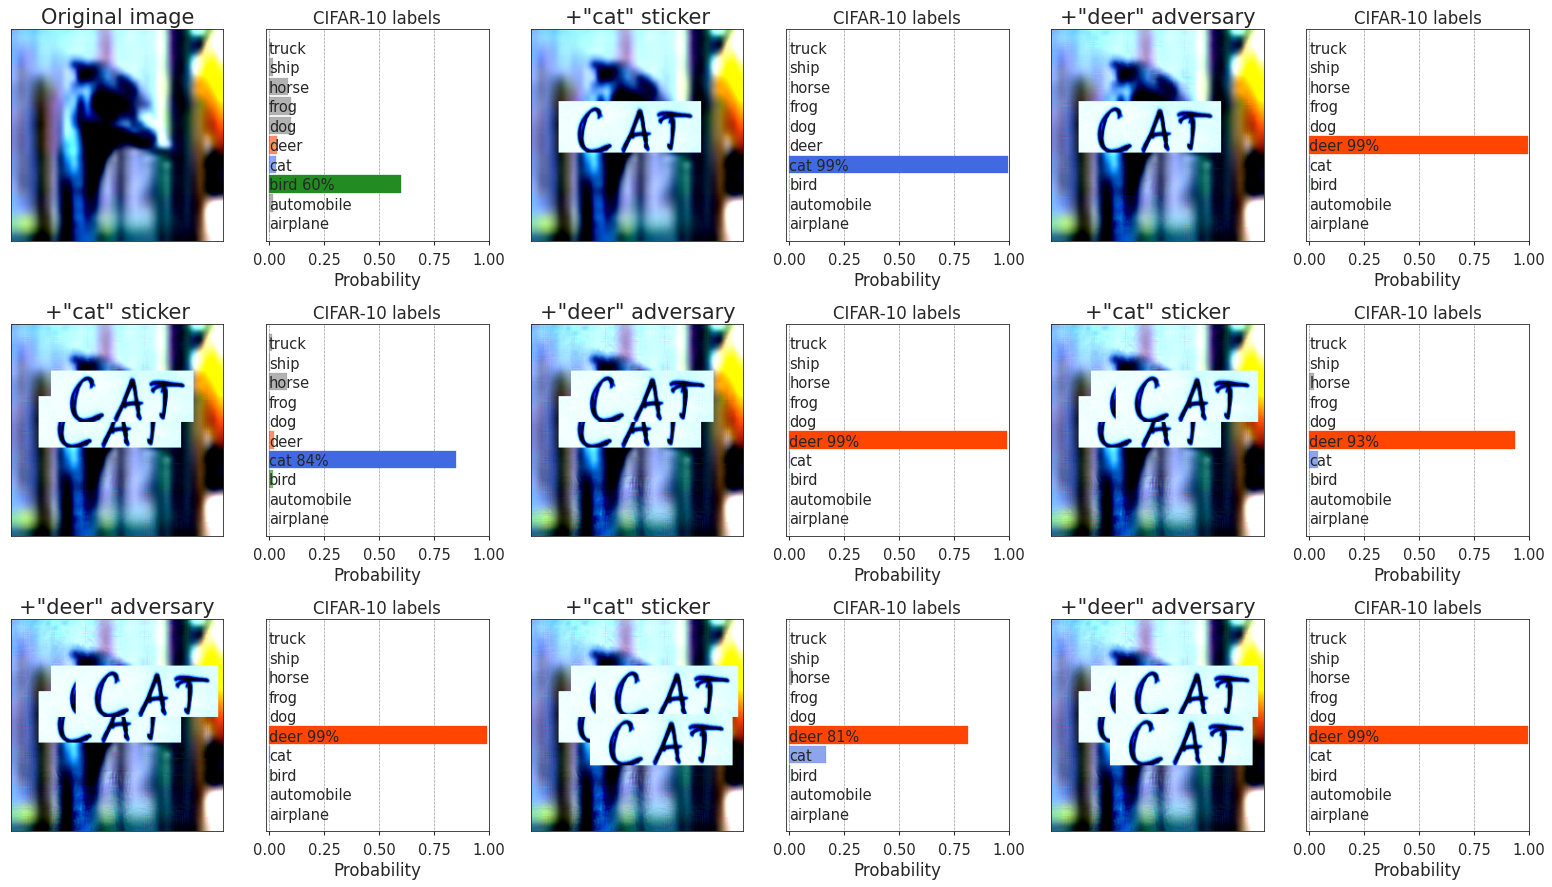

In [41]:
per_row = 6
rows = int(np.ceil(float(len(images_list)*2) / float(per_row)))

plt.figure(figsize = (per_row*3.5,rows*4),dpi = 75)

for i,image_np in enumerate(images_list):

  plt.subplot(rows,per_row,1+i*2+1)
  plt.title("CIFAR-10 labels",fontsize = 16)

  if i == 0:
    colors = ["forestgreen"]
  elif i % 2 == 1:
    colors = ["royalblue"]
  else:
    colors = ["orangered"]

  colors = {
      true_label: "forestgreen",
      target_label: "orangered",
      sticker_c: "royalblue",
  }

  v3_make_plot_from_preds(preds_now[i],class_names,colors = colors)

  plt.subplot(rows,per_row,1+i*2)
  
  if i == 0:
    title = "Original image"
  elif i % 2 == 0:
    title = "+\""+str(class_names[target_label])+"\" adversary"
  else:
    title = "+\""+str(class_names[sticker_c])+"\" sticker"


  plt.title(title,fontsize = 20)
  plt.imshow(image_np[0].transpose([1,2,0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

plt.tight_layout()

plt.show()